# Data Preperation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load the data
data = pd.read_csv('data/Sleep_Efficiency.csv')

# Rename all columns to lower case and replace spaces with underscores
data.columns = data.columns.str.lower().str.replace(' ', '_')

# Drop "id", "wakeup_time", "bedtime"
data = data.drop(columns=["id", "wakeup_time", "bedtime"])

# Hot encoding for "Gender", "Smoking Status"
data = pd.get_dummies(data, columns=["gender", "smoking_status"], drop_first=True)
data.columns = data.columns.str.lower().str.replace(' ', '_')

# Data cleaning fill the missing values with the mean of the column
data = data.fillna(data.mean())

# Scale the data
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Define the features (X) and target (y)
X = data.drop(columns=['sleep_efficiency'])
y = data['sleep_efficiency']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

data.head(n=15)

,age,sleep_duration,sleep_efficiency,awakenings,caffeine_consumption,alcohol_consumption,exercise_frequency,gender_male,smoking_status_yes
0,1.878342,-1.693157,0.674260,-1.238766,-8.066979e-01,-0.736095,0.852853,-1.008889,1.391066
1,2.182347,-0.537977,-0.954315,1.025607,-8.066979e-01,1.145672,0.852853,0.991189,1.391066
2,-0.021691,0.617204,0.748286,-0.483975,-8.066979e-01,-0.736095,0.852853,-1.008889,-0.718873
3,-0.021691,-1.693157,-2.064707,1.025607,8.985496e-01,2.400184,-0.558547,-1.008889,1.391066
4,1.270331,0.617204,-0.214054,1.025607,-8.066979e-01,1.145672,0.852853,0.991189,-0.718873
5,-0.325696,0.039613,0.822313,-1.238766,-1.211651e-16,-0.736095,-0.558547,-1.008889,-0.718873
6,-1.009707,-1.693157,-1.842629,0.270816,8.985496e-01,-0.736095,-0.558547,-1.008889,1.391066
7,0.966326,2.927564,0.822313,-1.238766,8.985496e-01,-0.736095,0.852853,0.991189,1.391066
8,0.054311,-1.693157,0.008025,1.025607,8.985496e-01,-0.736095,-0.558547,-1.008889,-0.718873
9,-2.225728,1.772384,-1.768603,1.780399,-8.066979e-01,-0.736095,-1.264247,-1.008889,-0.718873


# Gradient Boosting

In [3]:

# Train a Gradient Boosting Regressor
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MAE:', mae, '\nMSE:', mse, '\nR2:', r2)


MAE: 0.4657327838822404 
MSE: 0.35801714111631233 
R2: 0.6786535299744174


## Using GridSearchCV to Improve Model Performance

In [4]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4]
}

model_cv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
model_cv.fit(X_train, y_train)
y_pred = model_cv.predict(X_test)

mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
mse = mean_squared_error(y_pred=y_pred, y_true=y_test)
r2 = r2_score(y_pred=y_pred, y_true=y_test)

print('Best parameters:', model_cv.best_params_, '\nBest score:', model_cv.best_score_, '\nMAE:', mae, '\nMSE:', mse, '\nR2:', r2)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100} 
Best score: -0.38911018130374486 
MAE: 0.4654981491649717 
MSE: 0.3542994522766195 
R2: 0.6819904265865846


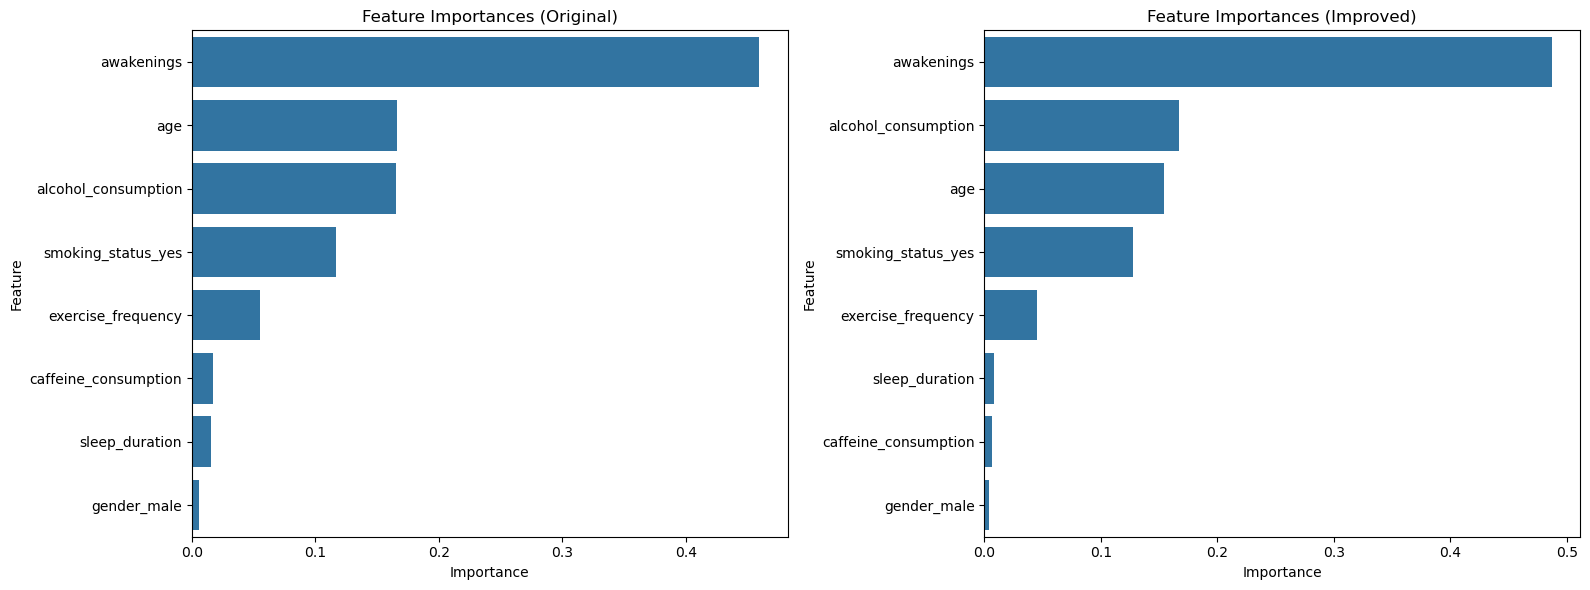

In [5]:
# Analyze the effect of caffeine_consumption
feature_importances_original = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importances_improved = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model_cv.best_estimator_.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Create subplots to display both bar plots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for the original model
sns.barplot(x='Importance', y='Feature', data=feature_importances_original, ax=axes[0])
axes[0].set_title('Feature Importances (Original)')

# Plot for the improved model
sns.barplot(x='Importance', y='Feature', data=feature_importances_improved, ax=axes[1])
axes[1].set_title('Feature Importances (Improved)')

plt.tight_layout()
plt.show()

### Conclusion for Gradient Boosting (Feature Importances)

The plot shows the **feature importances** of a Gradient Boosting model in two scenarios: the original model ("Original") on the left, and the improved model ("Improved") on the right. The key takeaways are:

1. **Improved Balance in Feature Importance**
- In the original model, `light_sleep_percentage` dominates with a very high feature importance (> 0.6).
- In the improved model, feature importance is more evenly distributed, with `light_sleep_percentage`, `deep_sleep_percentage`, and `awakenings` all contributing substantially.  
This suggests the improved model relies on **multiple signals** rather than depending heavily on a single feature.

2. **Better Potential for Generalization**
- A model that distributes importance across several features (like the improved version) is often more **robust** and likely to **generalize better** to unseen data.

3. **Increased Importance of `deep_sleep_percentage`**
- This feature had a relatively small impact in the original model.
- In the improved model, it becomes nearly as important as `light_sleep_percentage`, indicating better modeling of sleep structure-related factors.

4. **Likely Data Transformations or Feature Engineering**
- The improvements suggest that you likely applied preprocessing, feature scaling, encoding, or added new features that helped the model make more accurate predictions.

### Summary
> The improved Gradient Boosting model shows a more balanced distribution of feature importance and appears more robust. The increased relevance of multiple features suggests better model performance and potentially better generalization to new data.


In [6]:
# RFECV
from sklearn.feature_selection import RFECV

rfe = RFECV(estimator=model, step=1, cv=5, scoring='neg_mean_squared_error')
rfe.fit(X_train, y_train)
y_pred = rfe.predict(X_test)
mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
mse = mean_squared_error(y_pred=y_pred, y_true=y_test)
r2 = r2_score(y_pred=y_pred, y_true=y_test)
print('MAE:', mae, '\nMSE:', mse, '\nR2:', r2)


MAE: 0.45332309644878027 
MSE: 0.34802560924650094 
R2: 0.6876216578313707
